<a href="https://colab.research.google.com/github/GANPSO/DFCA-GAN-U-Net/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GAN** (generate images and masks)

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from PIL import Image
import matplotlib.pyplot as plt

# Set device
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8

# Paths
image_path = '/content/drive/MyDrive/ISIC 2016/train'
mask_path = '/content/drive/MyDrive/ISIC 2016/train_masks'

# Transformations for images (RGB)
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize for RGB images
])

# Transformations for masks (grayscale)
mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()  # No normalization for masks
])

# Dataset for images and masks
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to RGB for color images
        mask = Image.open(mask_path).convert("L")  # Grayscale mask
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

# DataLoader
dataset = ImageMaskDataset(image_dir=image_path, mask_dir=mask_path, image_transform=image_transform, mask_transform=mask_transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

# Generator (RGB + Mask Output)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),  # Output RGB Image
            nn.Tanh()  # For RGB image output
        )

        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),  # Output single-channel Mask (grayscale)
            nn.Sigmoid()  # Sigmoid to ensure mask values are between 0 and 1
        )

    def forward(self, input):
        image_output = self.main(input)
        mask_output = self.mask_head(input)
        return image_output, mask_output

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),  # Input: concatenated image + mask (RGB + mask)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize models
latent_dim = 100
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

# Loss and optimizers
adversarial_loss = nn.BCELoss()
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Mask loss function
def mask_loss(pred_mask, real_mask):
    criterion = nn.BCELoss()  # Now we use BCE loss, as the mask is binary (0 or 1)
    return criterion(pred_mask, real_mask)

# Training loop
num_epochs = 40
os.makedirs('generated_images', exist_ok=True)
os.makedirs('generated_masks', exist_ok=True)

for epoch in range(1, num_epochs + 1):
    for real_images, real_masks in train_loader:
        real_images = real_images.to(device)
        real_masks = real_masks.to(device)
        real_targets = torch.ones(real_images.size(0), device=device)  # Shape: (batch_size,)
        fake_targets = torch.zeros(real_images.size(0), device=device)  # Shape: (batch_size,)

        # Train Discriminator
        D_optimizer.zero_grad()
        real_pairs = torch.cat((real_images, real_masks), dim=1)  # Concatenate image and mask
        D_real_loss = adversarial_loss(discriminator(real_pairs), real_targets)
        noise = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        fake_images, fake_masks = generator(noise)
        fake_pairs = torch.cat((fake_images, fake_masks), dim=1)  # Concatenate fake image and mask
        D_fake_loss = adversarial_loss(discriminator(fake_pairs.detach()), fake_targets)
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        G_optimizer.zero_grad()
        G_image_loss = adversarial_loss(discriminator(fake_pairs), real_targets)
        G_mask_loss = mask_loss(fake_masks, real_masks)  # Mask loss
        G_loss = G_image_loss + G_mask_loss  # Combined loss
        G_loss.backward()
        G_optimizer.step()

    print(f"Epoch {epoch}/{num_epochs}, D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

    # Save generated images and masks every 10 epochs
    if epoch % 10 == 0:
        save_image(fake_images, f'generated_images/epoch_{epoch}.png', normalize=True)
        save_image(fake_masks, f'generated_masks/epoch_{epoch}.png', normalize=True)


Epoch 1/40, D Loss: 0.1146, G Loss: 16.0685
Epoch 2/40, D Loss: 0.4084, G Loss: 7.8172
Epoch 3/40, D Loss: 0.2067, G Loss: 9.1529
Epoch 4/40, D Loss: 0.0289, G Loss: 7.5212
Epoch 5/40, D Loss: 0.4674, G Loss: 3.0814
Epoch 6/40, D Loss: 0.3186, G Loss: 4.3345
Epoch 7/40, D Loss: 1.5991, G Loss: 3.1890
Epoch 8/40, D Loss: 0.8465, G Loss: 3.9390
Epoch 9/40, D Loss: 0.8777, G Loss: 4.4164
Epoch 10/40, D Loss: 0.2115, G Loss: 5.1372
Epoch 11/40, D Loss: 2.0658, G Loss: 5.0272
Epoch 12/40, D Loss: 0.4307, G Loss: 4.8088
Epoch 13/40, D Loss: 1.0016, G Loss: 6.6518
Epoch 14/40, D Loss: 0.6417, G Loss: 1.7849
Epoch 15/40, D Loss: 1.1557, G Loss: 1.9142
Epoch 16/40, D Loss: 1.0649, G Loss: 3.0672
Epoch 17/40, D Loss: 3.9274, G Loss: 1.4649
Epoch 18/40, D Loss: 2.2266, G Loss: 2.5363
Epoch 19/40, D Loss: 0.4208, G Loss: 4.8345
Epoch 20/40, D Loss: 0.8904, G Loss: 3.6093
Epoch 21/40, D Loss: 1.6417, G Loss: 3.5857
Epoch 22/40, D Loss: 0.4409, G Loss: 3.4341
Epoch 23/40, D Loss: 1.5023, G Loss: 2.6

**Generate and save 3000 images with GAN**


In [ ]:
import os
import torch
from torchvision.utils import save_image

def generate_and_save_images(generator, num_images=500, latent_dim=3000, device='cuda', save_dir='generated'):
    os.makedirs(save_dir, exist_ok=True)  # Create directory to save images if it doesn't exist

    generator.eval()  # Set to evaluation mode
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Latent vector
    with torch.no_grad():  # No need to track gradients
        fake_images, fake_masks = generator(noise)  # Generate fake images and masks

    # Convert generated images and masks to the [0, 1] range
    fake_images = (fake_images + 1) / 2  # Tanh outputs [-1, 1], so we map them to [0, 1]
    fake_masks = (fake_masks + 1) / 2  # Same for masks if using Tanh

    # Save generated images and masks
    for i in range(num_images):
        # Save generated images
        save_image(fake_images[i], os.path.join(save_dir, f'fake_image_{i+1}.png'))

        # Save generated masks
        save_image(fake_masks[i], os.path.join(save_dir, f'fake_mask_{i+1}.png'), normalize=True)

    print(f"Saved {num_images} images and masks in '{save_dir}'")

# Example usage
generate_and_save_images(generator, num_images=3000, latent_dim=100, device='cuda', save_dir='generated')


Saved 3000 images and masks in 'generated'


**Evaluate 3000 (GAN) generated images and masks with pre-trained U-Net**

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


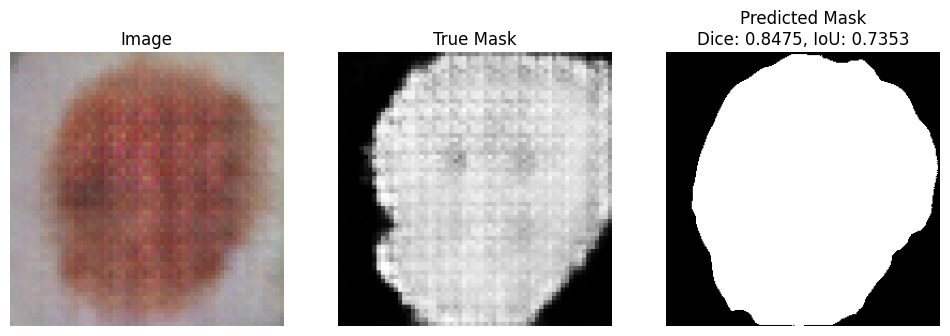

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


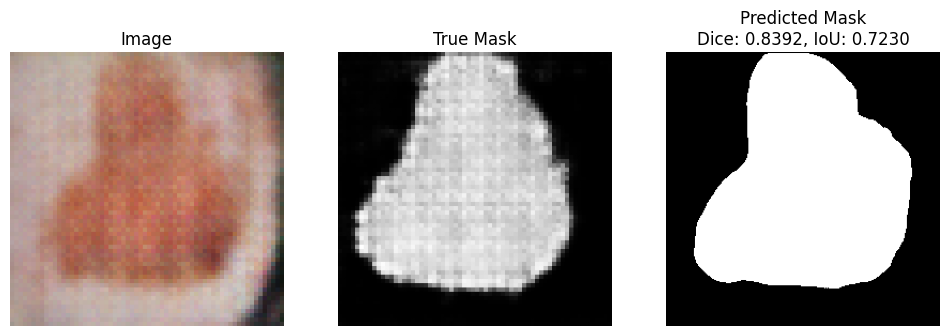

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


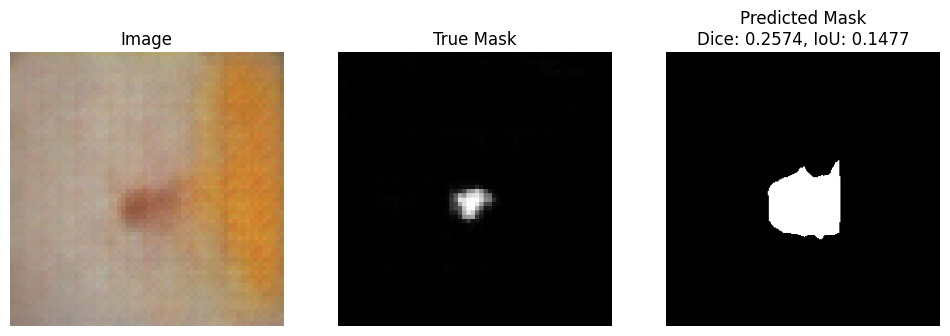

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


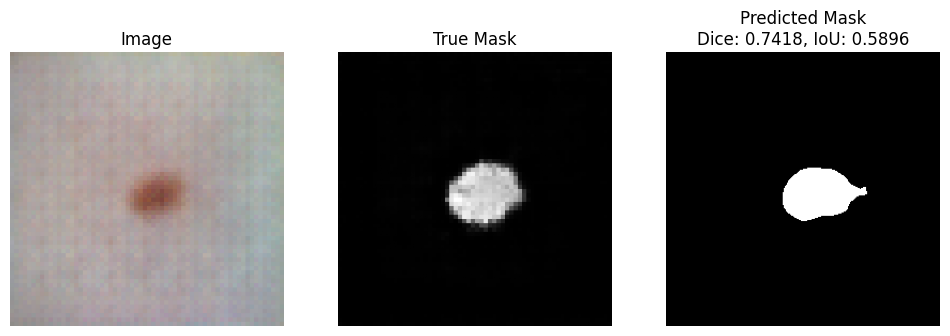

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


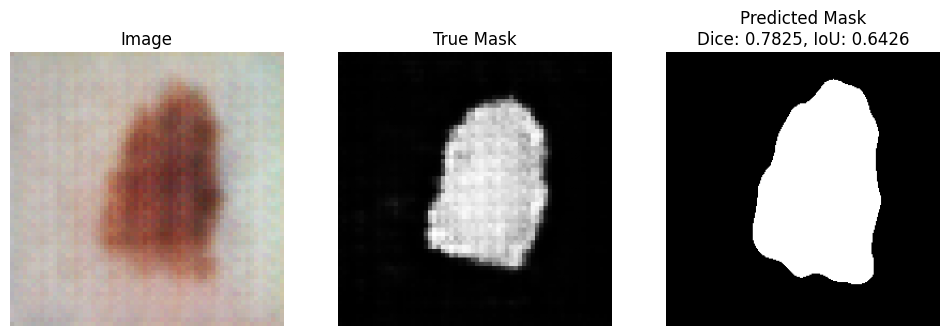

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf  # Ensure TensorFlow is imported


# Function to load and preprocess test images and masks
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_filenames, mask_filenames):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and preprocess the image and mask
        image = img_to_array(load_img(img_path, target_size=target_size)) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=target_size, color_mode="grayscale")) / 255.0

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Dice coefficient calculation
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

# Intersection over Union (IoU) calculation
def intersection_over_union(y_true, y_pred, smooth=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Display sample predictions
def display_sample_predictions(model, x_test, y_test, num_samples=5):
    indices = np.random.choice(len(x_test), num_samples, replace=False)

    for i in indices:
        image = x_test[i]
        true_mask = y_test[i]
        pred_mask = model.predict(image[np.newaxis, ...])[0]

        # Threshold the prediction
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Calculate Dice and IoU
        dice_score = dice_coefficient(true_mask, pred_mask).numpy()
        iou_score = intersection_over_union(true_mask, pred_mask).numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, 0], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, 0], cmap="gray")
        plt.title(f"Predicted Mask\nDice: {dice_score:.4f}, IoU: {iou_score:.4f}")
        plt.axis("off")

        plt.show()

# Evaluate metrics on the test set
def evaluate_metrics_on_test_set(model, x_test, y_test):
    dice_scores = []
    iou_scores = []

    for i in range(len(x_test)):
        true_mask = y_test[i]
        pred_mask = model.predict(x_test[i][np.newaxis, ...])[0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        dice_scores.append(dice_coefficient(true_mask, pred_mask).numpy())
        iou_scores.append(intersection_over_union(true_mask, pred_mask).numpy())

    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

# Load the trained U-Net model
model_path = "/content/drive/MyDrive/unet___model.h5"
model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient})

# Directories for generated images and masks
image_dir = "/content/drive/MyDrive/generatedIGAN"
mask_dir = "/content/drive/MyDrive/generatedMGAN"

# Load the test images and masks
x_test, y_test = load_images_and_masks(image_dir, mask_dir)

# Display sample predictions
display_sample_predictions(model, x_test, y_test, num_samples=5)

# Evaluate and display metrics
evaluate_metrics_on_test_set(model, x_test, y_test)
